In [6]:
import numpy as np
import random
from tqdm import tqdm
import statsmodels.api as sm

In [7]:
def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

# Generate all Covariates X variable
def fn_generate_multnorm(nobs, corr, nvar):
    std = (np.abs(np.random.normal(loc = 1, scale = 0.5,size = (nvar,1))))**(1/2)
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(0,std[i],nobs),(nobs,1)))
    
    normvars = np.concatenate(acc,axis=1)
    cov = fn_generate_cov(nvar)
    c = np.linalg.cholesky(cov)
    X = np.transpose(np.dot(c,np.transpose(normvars)))
    return X

# Generate Confounder variable C
def fn_randomize_conf(nobs):
    conf = np.reshape(np.random.normal(4,2,nobs),(nobs,1))
    return conf

# Generate Treatment variable T
def fn_randomize_treatment(nobs,C):
    T = []
    if conf==False:
        for i in range(nobs):
            t = np.random.choice(np.arange(0, 2), p=[0.5, 0.5])
            T.append(t)
    if conf==True:
        for i in range(nobs):
            t = np.random.choice(np.arange(0, 2), p=[0.5-0.025*float(C[i]), 0.5+0.025*float(C[i])])
            T.append(t)
    return np.reshape(T,(nobs,1))

# Generate Variable between the path from the treatment to the outcome S
def fn_randomize_s(nobs,T):
    S = []
    for i in range(nobs):
        s = np.random.choice(np.arange(0, 2), p=[0.5-0.1*float(T[i]), 0.5+0.1*float(T[i])])
        S.append(s)
    return np.reshape(S,(nobs,1))

# Generate Data
def fn_generate_data(tau,N,p,corr,conf,sv):

    if conf==False:
        conf_mult = 0 
    if conf==True:
        conf_mult = 1
    if sv==False:
        s_mult = 0
    if sv==True:
        s_mult = 1
    
    X = fn_generate_multnorm(N,corr,p)
    C = fn_randomize_conf(N)
    T = fn_randomize_treatment(N,C)
    S = fn_randomize_s(N,T)
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    Yab = tau*T+X@beta0+conf_mult*0.6*C+s_mult*1*S+err
        
    if conf==False and sv==False:
        return (Yab,T,X)   
    if conf==True and sv==False:
        return (Yab,T,X,C)
    if conf==False and sv==True:
        return (Yab,T,X,S)    
    if conf==True and sv==True:
        return (Yab,T,X,C,S) 

def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

# Return estimate tauhats and sehats
def fn_get_estimate(tau,Nrange,p,corr,conf,sv,control_conf,control_flagX,control_s):

    tauhats = []
    sehats = []
    for r in tqdm(Nrange):
        if conf==False and sv==False:
            if control_flagX==False:
                Yexp,T,X = fn_generate_data(tau,N,p,corr,conf,sv)
                Yt = Yexp[np.where(T==1)[0],:]
                Yc = Yexp[np.where(T==0)[0],:]
                tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)            
            if control_flagX==True:
                Yexp,T,X = fn_generate_data(tau,N,p,corr,conf,sv)
                covars = np.concatenate([T,X],axis = 1)
                mod = sm.OLS(Yexp,covars)
                res = mod.fit()
                tauhat = res.params[0]
                se_tauhat = res.HC1_se[0]
        if conf==True and sv==False:
            if control_conf==False:
                Yexp,T,X,C = fn_generate_data(tau,N,p,corr,conf,sv)
                covars = np.concatenate([T,X],axis = 1)
                mod = sm.OLS(Yexp,covars)
                res = mod.fit()
                tauhat = res.params[0]
                se_tauhat = res.HC1_se[0]
            if control_conf==True:
                Yexp,T,X,C = fn_generate_data(tau,N,p,corr,conf,sv)
                covars = np.concatenate([T,X,C],axis = 1)
                mod = sm.OLS(Yexp,covars)
                res = mod.fit()
                tauhat = res.params[0]
                se_tauhat = res.HC1_se[0]
        if conf==False and sv==True:
            if control_s==False:
                Yexp,T,X,S = fn_generate_data(tau,N,p,corr,conf,sv)
                covars = np.concatenate([T,X],axis = 1)
                mod = sm.OLS(Yexp,covars)
                res = mod.fit()
                tauhat = res.params[0]
                se_tauhat = res.HC1_se[0]
            if control_s==True:
                Yexp,T,X,S = fn_generate_data(tau,N,p,corr,conf,sv)
                covars = np.concatenate([T,X,S],axis = 1)
                mod = sm.OLS(Yexp,covars)
                res = mod.fit()
                tauhat = res.params[0]
                se_tauhat = res.HC1_se[0]
            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]          
    return (tauhats,sehats)

# Return bias,rmse,size of treatment effect estimate
def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat
    size = np.mean(1*(np.abs(tval)>cval))
    return (bias,rmse,size)

In [8]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import graphviz as gr

## 1. Simulate a DGP where the outcome of interest depends on a randomly assigned treatment and some observed covariates.

#### $y_i = \tau*T_i+\beta'*X_i+e_i$

##### 1.1 Simulate a DGP

In [9]:
tau = 3
corr = .5
conf = False
sv = False
p = 3
N = 1000
(Yab,T,X) = fn_generate_data(tau,N,p,corr,conf,sv)
data1 = np.concatenate((Yab,T,X),axis=1)
Data1 = pd.DataFrame(np.array(data1), columns=['Y','T','x1','x2','x3',])
Data1

,Y,T,x1,x2,x3
0,-4.770389,0.0,-0.633011,0.260157,1.580404
1,-1.588500,0.0,0.128565,-0.807417,-1.320712
2,-1.442788,0.0,0.036485,0.100050,0.589728
3,7.177118,1.0,0.702920,0.921045,1.384016
4,16.278818,0.0,-0.280786,1.083508,-1.164310
...,...,...,...,...,...
995,15.036237,0.0,1.534872,2.162643,2.566758
996,-1.897108,1.0,0.069672,-0.076384,0.853232
997,-5.419697,1.0,-1.244047,-0.221016,0.479760
998,9.318819,0.0,0.131696,0.978197,-0.005969


##### 1.2 Illustrate the DGP with a DAG

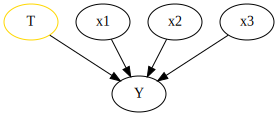

In [10]:
g = gr.Digraph()
g.edge("T", "Y"),g.node("T", color="gold")
g.edge("x1", "Y"),g.edge("x2", "Y"),g.edge("x3", "Y")
g

##### 1.3 Using a Monte Carlo experiment

a. Do not control for any covariates

In [11]:
control_conf=False
control_flagX=False
control_s=False
estDict = {}
Nrange = range(2000)
for N in [100,1000]:
    tauhats,sehats = fn_get_estimate(tau,Nrange,p,corr,conf,sv,control_conf,control_flagX,control_s)
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

tau0 = tau*np.ones([len(Nrange),1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

100%|██████████| 2000/2000 [01:27<00:00, 22.93it/s]

N=100: bias=-0.040909369580773944, RMSE=2.964908904185278, size=0.0505
N=1000: bias=-0.06500538194902461, RMSE=0.9724044329497633, size=0.048


b. Control for all the covariates that affect the outcome

In [12]:
control_conf=False
control_flagX=True
control_sv=False
estDict = {}
Nrange = range(2000)
for N in [100,1000]:
    tauhats,sehats = fn_get_estimate(tau,Nrange,p,corr,conf,sv,control_conf,control_flagX,control_s)
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

tau0 = tau*np.ones([len(Nrange),1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

100%|██████████| 2000/2000 [01:28<00:00, 22.58it/s]

N=100: bias=0.0012957980509062399, RMSE=0.14498675404938424, size=0.063
N=1000: bias=0.00024020785406806344, RMSE=0.04463797527854177, size=0.0465


##### 1.4 Give an example of a real-life situation that might be consistent with the DGP.

### If we want to estimate the effects of products' supply or demand on the price, the products quality, the substitued products will also make an impact on the price.

## 2. Simulate a DGP with a confounder

#### $y_i = \tau*T_i+\beta'*X_i+\alpha'*C_i+e_i$

##### 2.1 Simulate a DGP

In [13]:
tau = 4
corr = .4
conf = True
flagX = True
sv = False
p = 3
N = 1000
(Yab,T,X,C) = fn_generate_data(tau,N,p,corr,conf,sv)
data2 = np.concatenate((Yab,T,X,C),axis=1)
Data2 = pd.DataFrame(np.array(data2), columns=['Y','T','x1','x2','x3','C'])
Data2

,Y,T,x1,x2,x3,C
0,-10.140324,0.0,-0.868058,-0.975060,0.282701,5.126124
1,8.842112,0.0,-0.077431,0.560223,0.413887,4.457124
2,31.554503,0.0,2.801560,1.753165,1.707195,5.233431
3,-7.735769,0.0,-0.962272,-0.901233,0.689423,6.517585
4,27.226355,1.0,2.462362,1.101085,0.607713,5.145643
...,...,...,...,...,...,...
995,22.412609,0.0,0.063677,2.003209,-0.124146,4.472489
996,12.001794,1.0,0.106436,0.307966,1.304395,4.831733
997,-2.718274,1.0,0.392765,-0.865853,-0.254300,0.905682
998,6.872969,1.0,1.319173,-0.438139,-0.332230,5.439883


##### 2.2 Illustrate the DGP with a DAG

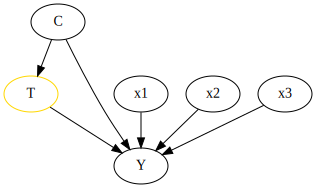

In [14]:
g = gr.Digraph()
g.edge("T", "Y"),g.node("T", color="gold")
g.edge("C", "T"),g.edge("C", "Y")
g.edge("x1", "Y"),g.edge("x2", "Y"),g.edge("x3", "Y")
g

##### 2.3 Using a Monte Carlo experiment

a. Fail to control for the confounder

In [15]:
control_conf=False
control_flagX=True
control_s=False
estDict = {}
Nrange = range(2000)
for N in [100,1000]:
    tauhats,sehats = fn_get_estimate(tau,Nrange,p,corr,conf,sv,control_conf,control_flagX,control_s)
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

tau0 = tau*np.ones([len(Nrange),1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

100%|██████████| 2000/2000 [01:36<00:00, 20.75it/s]

N=100: bias=2.500226012813356, RMSE=2.5088307885056405, size=1.0
N=1000: bias=2.4991797552288446, RMSE=2.5000281769333186, size=1.0


b. Do control for the confounder

In [16]:
control_conf=True
control_flagX=True
control_s=False
estDict = {}
Nrange = range(1000)
for N in [100,1000]:
    tauhats,sehats = fn_get_estimate(tau,Nrange,p,corr,conf,sv,control_conf,control_flagX,control_s)
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

tau0 = tau*np.ones([len(Nrange),1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

100%|██████████| 1000/1000 [00:46<00:00, 21.73it/s]

N=100: bias=-0.0038123669324337094, RMSE=0.1862925987368063, size=0.05
N=1000: bias=-0.0008611626929361806, RMSE=0.058680393734154984, size=0.048


##### 2.4 Give an example of a real-life situation that might be consistent with the DGP


### If we want to estimate the effect of education on income, the variable IQ not only affects the education but also affects the income, so we need to control it. 

## 3. Simulate a DGP with selection bias into the treatment

#### $y_i = \tau*T_i+\beta'*X_i+\alpha'*C_i+e_i$

##### 3.1 Simulate a DGP

In [17]:
tau = 5
corr = .5
conf = False
flagX = True
sv = True
p = 3
N = 1000
(Yab,T,X,S) = fn_generate_data(tau,N,p,corr,conf,sv)
data3 = np.concatenate((Yab,T,X,S),axis=1)
Data3 = pd.DataFrame(np.array(data3), columns=['Y','T','x1','x2','x3','S'])
Data3

,Y,T,x1,x2,x3,S
0,13.138159,0.0,-0.083689,0.713922,1.834553,0.0
1,19.586490,1.0,0.354039,0.848232,1.514666,1.0
2,0.254492,1.0,-0.253937,-0.304467,-0.256958,0.0
3,-16.456233,0.0,-1.385533,-0.698831,-0.756035,1.0
4,4.299364,1.0,0.181130,-0.058708,-0.796547,1.0
...,...,...,...,...,...,...
995,-10.841713,1.0,-0.243575,-1.622388,-1.058402,1.0
996,9.432907,1.0,0.513464,0.193306,-0.083700,0.0
997,15.033052,1.0,0.347757,0.413640,1.290915,0.0
998,3.382279,0.0,0.590589,0.472126,-0.908249,0.0


##### 3.2 Illustrate the DGP with a DAG

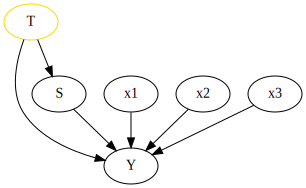

In [18]:
g = gr.Digraph()
g.edge("T", "Y"),g.node("T", color="gold")
g.edge("T", "S"),g.edge("S", "Y")
g.edge("x1", "Y"),g.edge("x2", "Y"),g.edge("x3", "Y")
g

##### 3.3 Using a Monte Carlo experiment

a. Control for the variable in between the path from cause to effect

In [19]:
control_conf=False
control_flagX=True
control_s=True
estDict = {}
Nrange = range(2000)
for N in [100,1000]:
    tauhats,sehats = fn_get_estimate(tau,Nrange,p,corr,conf,sv,control_conf,control_flagX,control_s)
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

tau0 = (tau+0.6)*np.ones([len(Nrange),1]) # 0.6 is the probability of S get 1
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

100%|██████████| 2000/2000 [01:27<00:00, 22.75it/s]

N=100: bias=-0.6005018663047108, RMSE=0.6246712243532273, size=0.9225
N=1000: bias=-0.5992596937961571, RMSE=0.6018084972364307, size=1.0


b. Do not control for the variable in between the path from cause to effect

In [20]:
control_conf=False
control_flagX=True
control_s=False
estDict = {}
Nrange = range(2000)
for N in [100,1000]:
    tauhats,sehats = fn_get_estimate(tau,Nrange,p,corr,conf,sv,control_conf,control_flagX,control_s)
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

tau0 = (tau+0.6)*np.ones([len(Nrange),1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

100%|██████████| 2000/2000 [01:29<00:00, 22.37it/s]

N=100: bias=-0.004676442715982141, RMSE=0.1643700057404396, size=0.064
N=1000: bias=0.0005542085198565627, RMSE=0.04935351947152827, size=0.048


##### 3.4 Give an example of a real-life situation that might be consistent with the DGP

### Take email as an example, we discuss the effect of email on buying goods, when receiving the email, consumers will more likely to open the link and buying goods. If controlling the possibility of opening the link, then we cannot estimate the effect.